# K-Means Demo

KMeans is a basic but powerful clustering method which is optimized via Expectation Maximization. It randomnly selects K data points in X, and computes which samples are close to these points. For every cluster of points, a mean is computed, and this becomes the new centroid.

cuML’s KMeans supports the scalable KMeans++ intialization method. This method is more stable than randomnly selecting K points.
    
The model can take array-like objects, either in host as NumPy arrays or in device (as Numba or _cuda_array_interface_compliant), as well as cuDF DataFrames as the input.

For information on converting your dataset to cuDF format, refer to the [cuDF documentation](https://rapidsai.github.io/projects/cudf/en/latest/)

For additional information on cuML's k-means implementation: https://rapidsai.github.io/projects/cuml/en/latest/api.html#k-means-clustering

In [4]:
import numpy as np

import pandas as pd
import cudf as gd

from cuml.datasets import make_blobs

from sklearn.metrics import adjusted_rand_score

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans as skKMeans
from cuml.cluster import KMeans as cumlKMeans

## Define Parameters

In [5]:
n_samples = 100000
n_features = 2

## Generate Data

### Device

In [6]:
device_data, device_labels = make_blobs(
   n_samples=n_samples, n_features=n_features, centers=5, random_state=7)

device_data = gd.DataFrame.from_gpu_matrix(device_data)
device_labels = gd.Series(device_labels)

### Host

In [7]:
host_data = device_data.to_pandas()
host_labels = device_labels.to_pandas()

## Scikit-learn model

In [8]:
%%time
kmeans_sk = skKMeans(n_clusters=5,
                     n_jobs=-1)
kmeans_sk.fit(host_data)

CPU times: user 328 ms, sys: 2.16 s, total: 2.49 s
Wall time: 3.23 s


## cuML Model

In [9]:
%%time
kmeans_cuml = cumlKMeans(n_clusters=5)
kmeans_cuml.fit(device_data)

CPU times: user 588 ms, sys: 40 ms, total: 628 ms
Wall time: 711 ms


## Visualize Centroids

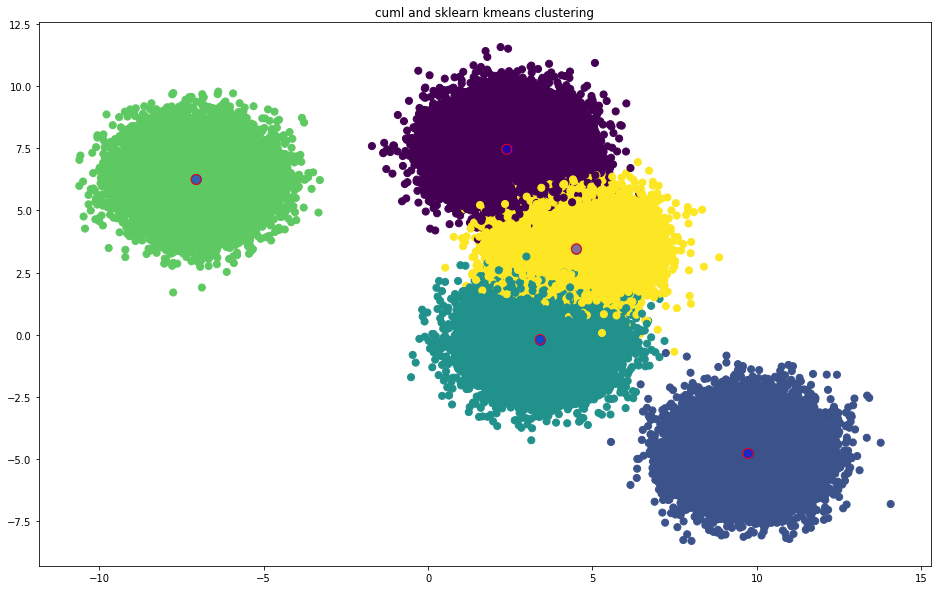

In [16]:
fig = plt.figure(figsize=(16, 10))
plt.scatter(host_data[:, 0], host_data[:, 1], c=host_labels, s=50, cmap='viridis')

#plot the sklearn kmeans centers with blue filled circles
centers_sk = kmeans_sk.cluster_centers_
plt.scatter(centers_sk[:,0], centers_sk[:,1], c='blue', s=100, alpha=.5)

#plot the cuml kmeans centers with red circle outlines
centers_cuml = kmeans_cuml.cluster_centers_
plt.scatter(centers_cuml['0'], centers_cuml['1'], facecolors = 'none', edgecolors='red', s=100)

plt.title('cuml and sklearn kmeans clustering')

plt.show()

## Compare Results

In [17]:
%%time
cuml_score = adjusted_rand_score(host_labels, kmeans_cuml.labels_)
sk_score = adjusted_rand_score(host_labels, kmeans_sk.labels_)

CPU times: user 26 s, sys: 416 ms, total: 26.5 s
Wall time: 26.5 s


In [21]:
threshold = 1e-4

passed = (cuml_score - sk_score) < threshold
print('compare kmeans: cuml vs sklearn labels_ are ' + ('equal' if passed else 'NOT equal'))

compare kmeans: cuml vs sklearn labels_ are equal
